In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import pickle

In [3]:
with open("data/sdm_predictions/results.pkl", "rb") as f:
    results_df = pickle.load(f)


/var/folders/vm/9ws15vws62zgnr64rdr_ls5r0000gn/T/ipykernel_12797/2897148618.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  results_df = pickle.load(f)


In [4]:
def load_ev_df() -> pd.DataFrame:
    evs = rxr.open_rasterio("data/sdm_predictions/evs.tif")
    evs.coords["band"] = list(evs.attrs["long_name"])
    evs = evs.to_dataset(dim="band")

    ev_df = evs.to_dataframe()
    ev_df.drop("spatial_ref", axis=1, inplace=True)
    ev_df.dropna(inplace=True)

    return ev_df


In [5]:
ev_df =  load_ev_df()
feature_names = ev_df.columns.tolist()

In [6]:
from sklearn.inspection import PartialDependenceDisplay
def partial_dependence_df(model, X_df, features:list):
    display = PartialDependenceDisplay.from_estimator(
    model, X_df, features, grid_resolution=30, n_jobs=-1
    )
    # Convert the PD results to a dataframe
    pd_results_df = pd.DataFrame(
        [
            {
                "feature": name,
                "values": result.grid_values[0],
                "average": result.average[0],
            } for result, name in zip(display.pd_results, display.feature_names)
        ]
    )
    pd_results_df = pd_results_df.explode(["values", "average"])

    return pd_results_df

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:1289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


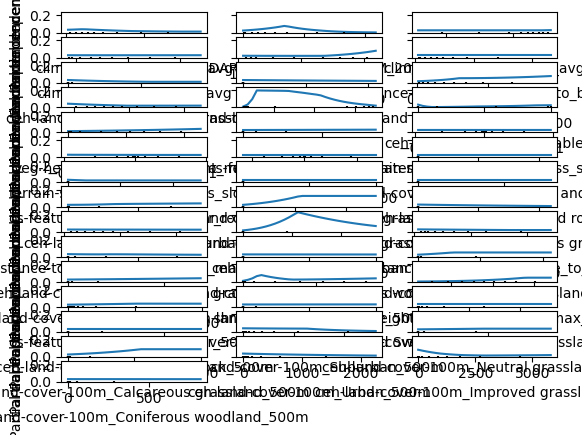

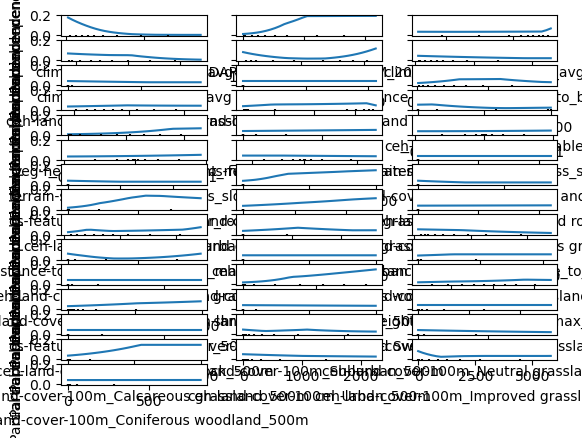

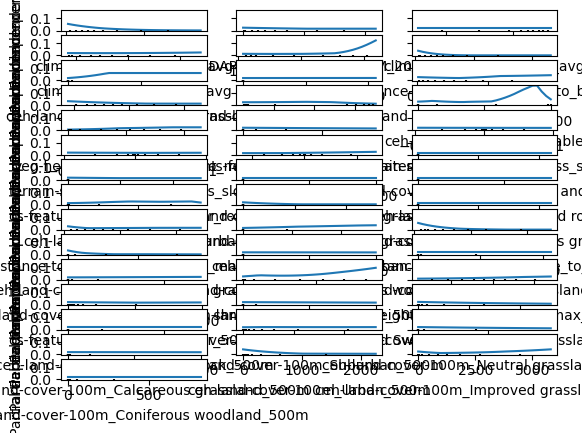

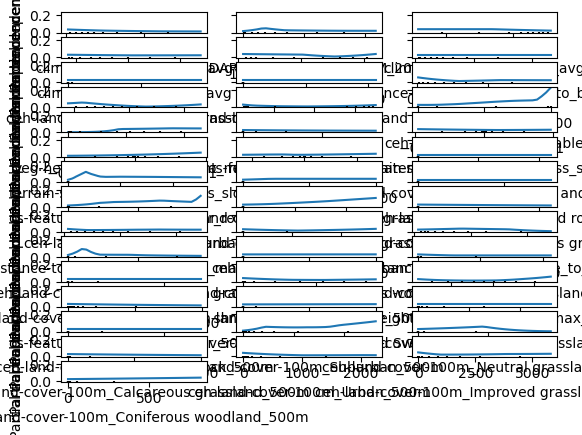

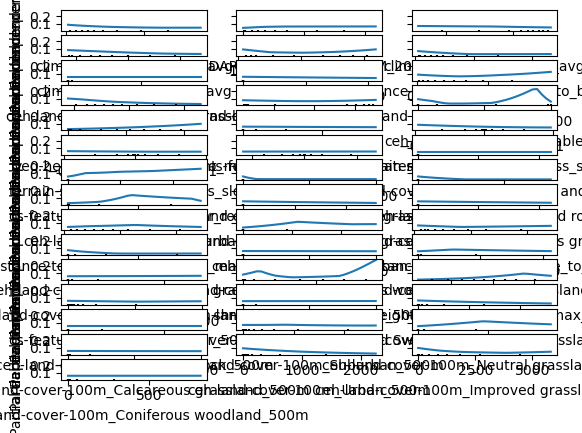

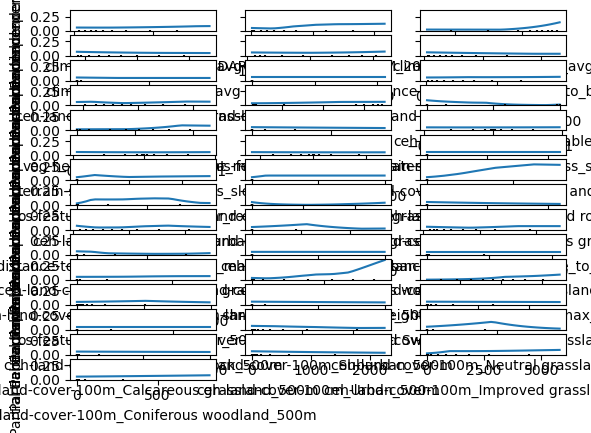

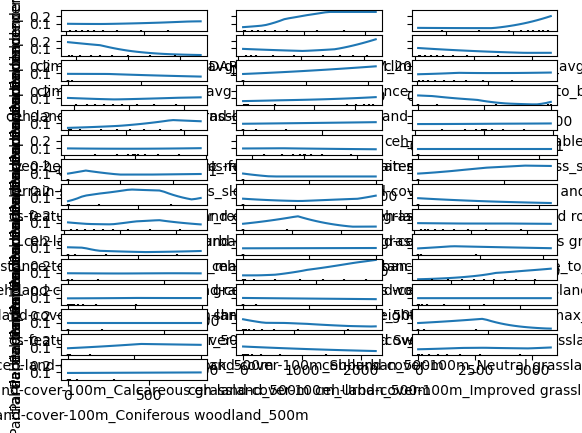

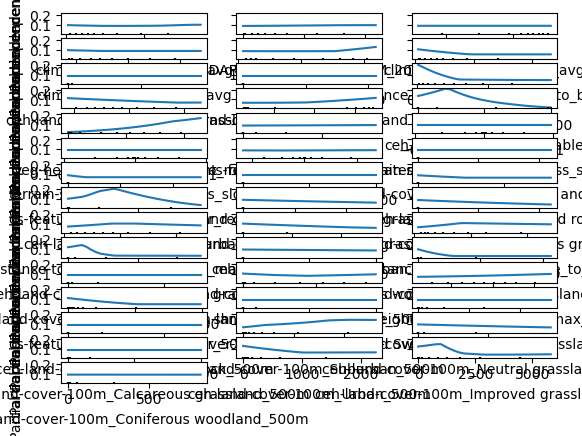

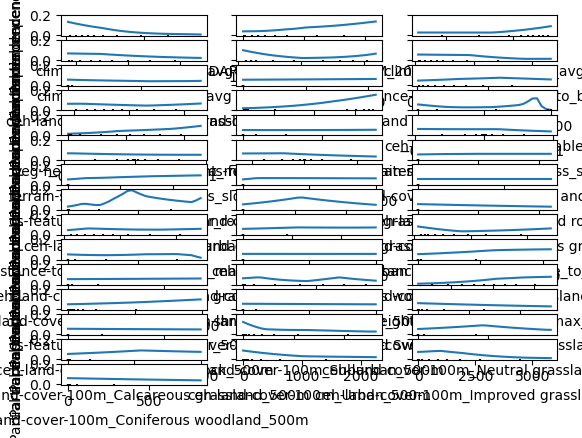

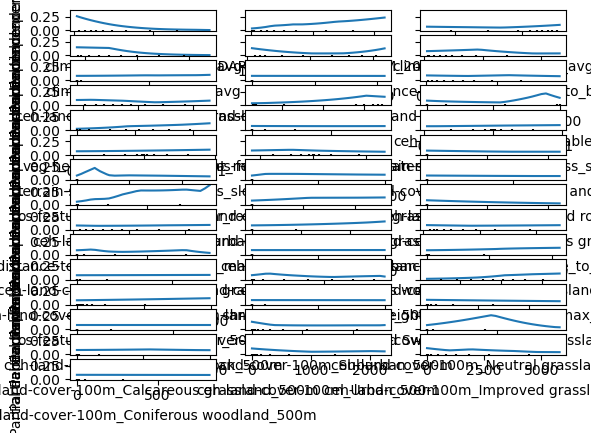

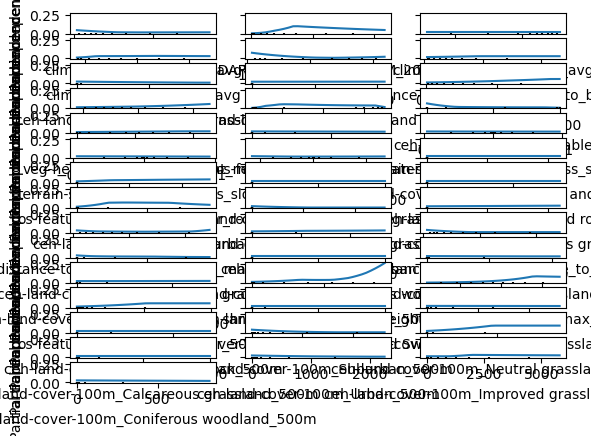

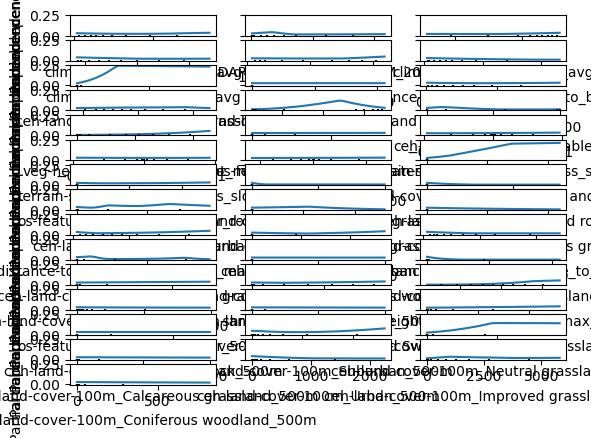

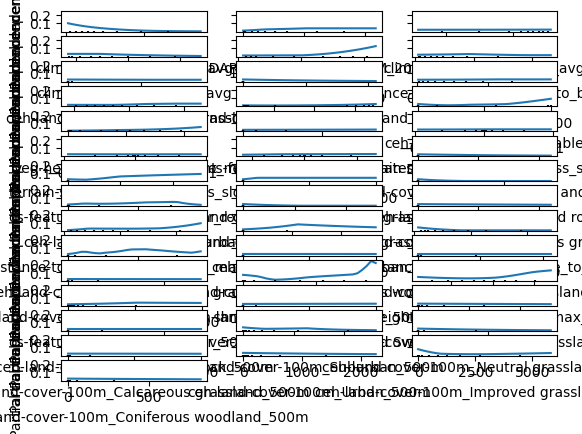

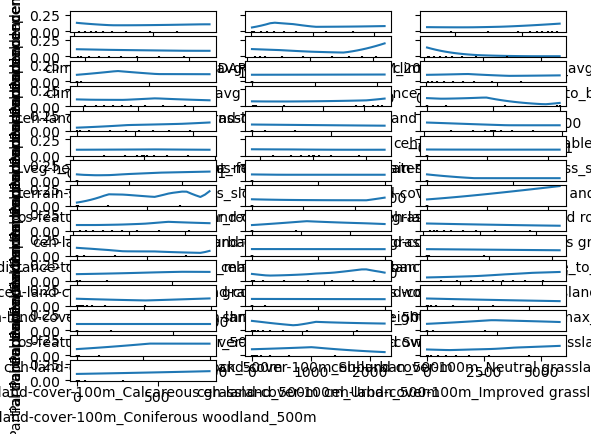

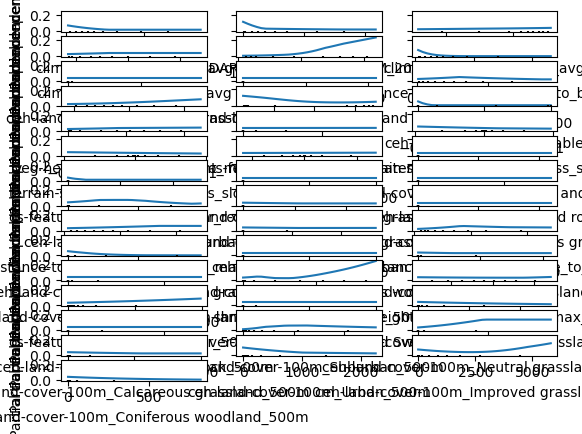

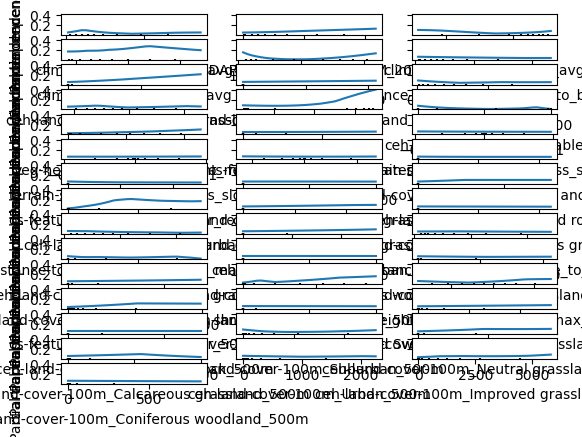

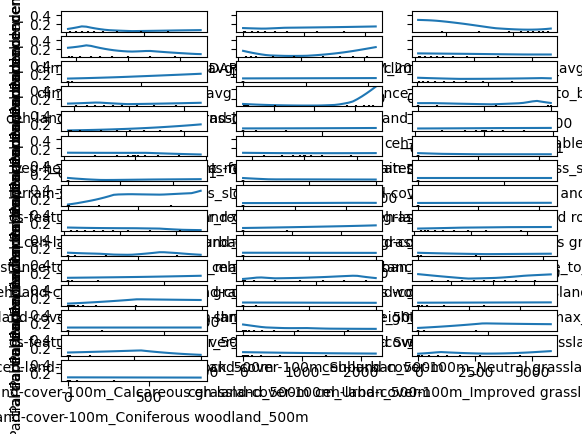

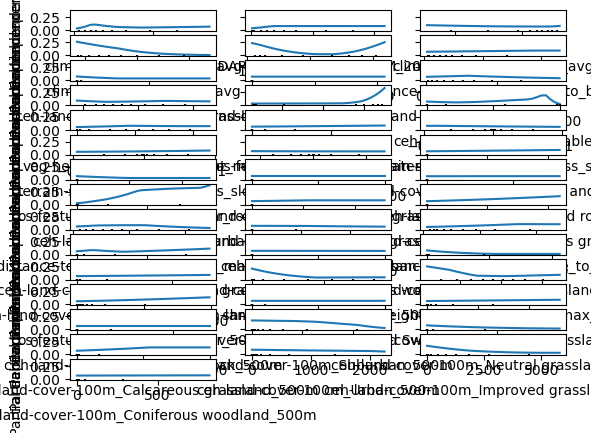

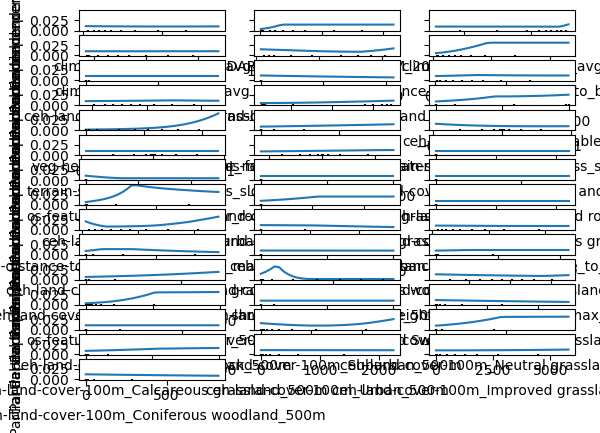

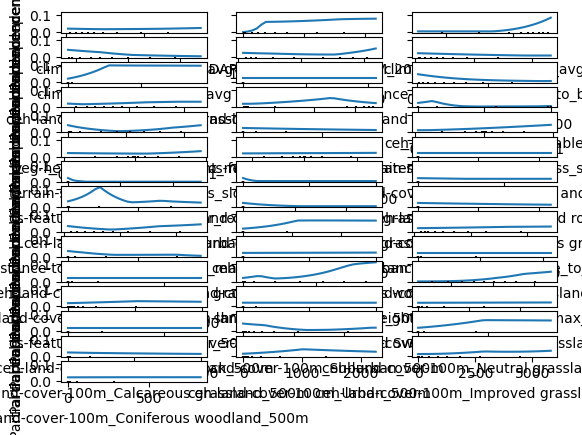

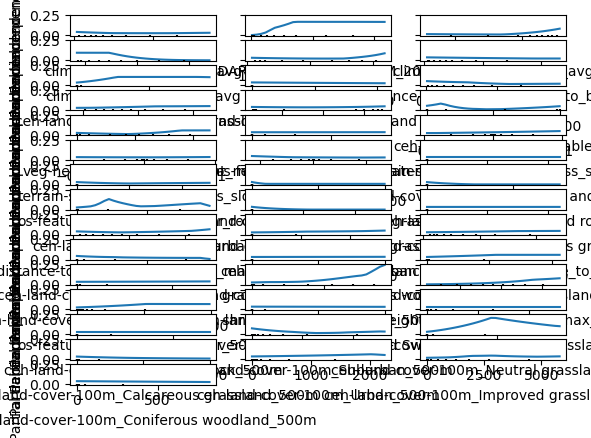

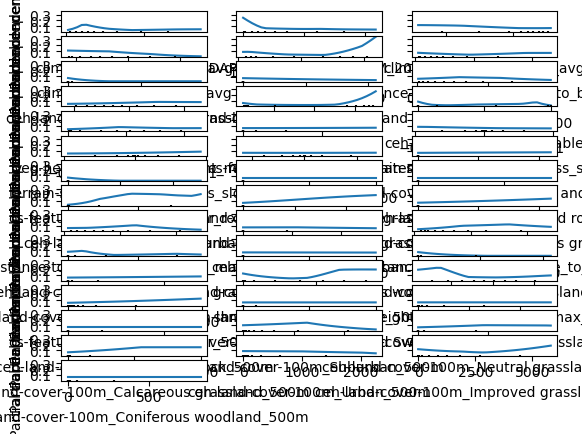

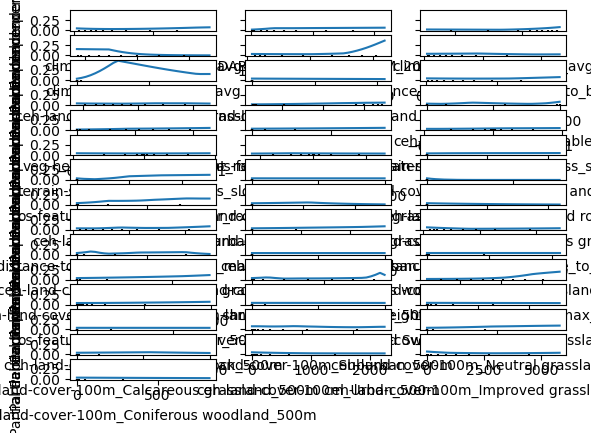

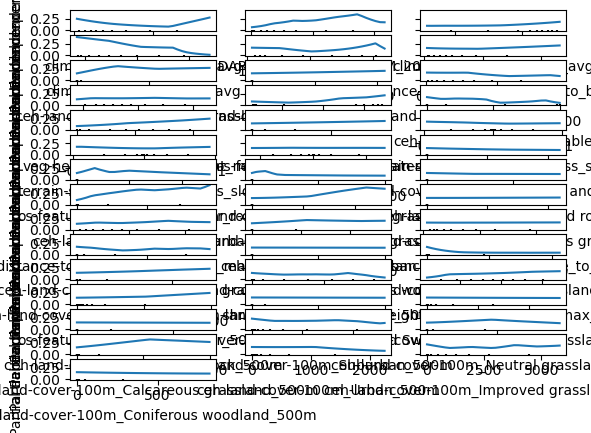

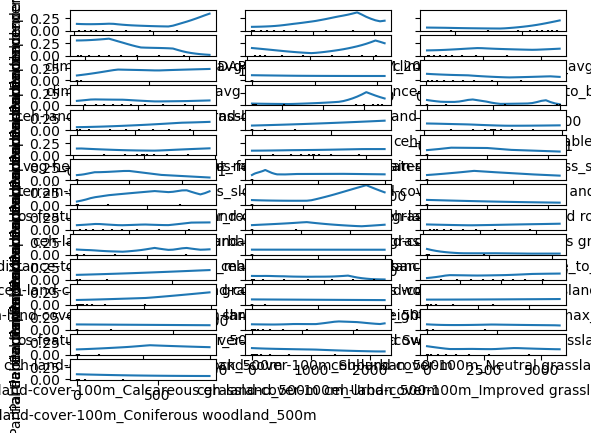

In [8]:
from tqdm.notebook import tqdm_notebook
ev_sample = ev_df.sample(1000)

partial_dependence_results = []
for _, row in tqdm_notebook(results_df.iterrows(), total=results_df.shape[0]):
    model = row.final_model

    pd_results_df = partial_dependence_df(model, ev_sample, feature_names)
    pd_results_df["latin_name"] = row.latin_name
    pd_results_df["activity_type"] = row.activity_type

    partial_dependence_results.append(pd_results_df)


In [9]:
# combine the results into one df and write to disk
partial_dependence_results = pd.concat(partial_dependence_results)
partial_dependence_results.to_csv("data/sdm_predictions/partial-dependence-data.csv", index=False)